PART 3 OF IMAGE COLORIZATION PROJECT

By Chetna Agarwal

In [ ]:
from keras.layers import Conv2D, UpSampling2D, Input
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import tensorflow as tf
import keras
import os

In [ ]:
# Replace the encoder part with VGG16. Use VGG 16 as a feature extractor and not a classifier.
# We can remove the last dense layer, adding 19 layers to our model. The dimensions of the last 
# volume are (7, 7, 512).
# Use the latent space volume as a feature vector to be input to the decoder. The decoder will
# learn the mapping from the latent space vector to the AB channel. 

In [ ]:
from keras.applications.vgg16 import VGG16
vggmodel = VGG16()
newmodel = Sequential() 
for i, layer in enumerate(vggmodel.layers):
    if i<19:          #Only up to 19th layer to include feature extraction only
      newmodel.add(layer)
newmodel.summary()
for layer in newmodel.layers:
  layer.trainable=False   #We don't want to train these layers again, so False. 

553476096/553467096 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_______________________________________________________

In [ ]:
# VGG expects an image of 3 dimensions of size (224, 224) as an input, in preprocessing
# we have to scale all the images to 224 instead of 256

In [ ]:
path = '/content/drive/MyDrive/Image colorizer/Train/'
#Normalize images - divide by 255
train_datagen = ImageDataGenerator(rescale=1. / 255)
train = train_datagen.flow_from_directory(path, target_size=(224, 224), batch_size=32, class_mode=None)

Found 801 images belonging to 1 classes.


In [ ]:
# convert RGB images to Lab
X =[]
Y =[]
for img in train[0]:
  try:
      lab = rgb2lab(img)
      X.append(lab[:,:,0]) 
      Y.append(lab[:,:,1:] / 128) #A and B values range from -127 to 128, 
      #so we divide the values by 128 to restrict values to between -1 and 1.
  except:
     print('error')
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,)) #dimensions to be the same for X and Y
print(X.shape)
print(Y.shape)

(32, 224, 224, 1)
(32, 224, 224, 2)


In [ ]:
# We have one channel of L in each layer but, VGG16 is expecting 3 dimensions, 
# so we repeat the L channel two times to get 3 dimensions of the same L channel

In [ ]:
vggfeatures = []
for i, sample in enumerate(X):
  sample = gray2rgb(sample)
  sample = sample.reshape((1,224,224,3))
  prediction = newmodel.predict(sample)
  prediction = prediction.reshape((7,7,512))
  vggfeatures.append(prediction)
vggfeatures = np.array(vggfeatures)
print(vggfeatures.shape)

(32, 7, 7, 512)


In [ ]:
#Decoder
model = Sequential()

model.add(Conv2D(256, (3,3), activation='relu', padding='same', input_shape=(7,7,512)))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.summary()

# train using google colab GPUs
model.compile(optimizer='Adam', loss='mse' , metrics=['accuracy'])
model.fit(vggfeatures, Y, verbose=1, epochs=2000, batch_size=128)
# ran for 4000 epochs 

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 1s 1s/step - loss: 0.0020 - accuracy: 0.9097
Epoch 1506/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0019 - accuracy: 0.9103
Epoch 1507/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0019 - accuracy: 0.9089
Epoch 1508/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0019 - accuracy: 0.9105
Epoch 1509/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0020 - accuracy: 0.9086
Epoch 1510/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0020 - accuracy: 0.9104
Epoch 1511/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0019 - accuracy: 0.9103
Epoch 1512/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0019 - accuracy: 0.9102
Epoch 1513/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0019 - accuracy: 0.9100
Epoch 1514/10000
1/1 [==============================] - 1

KeyboardInterrupt: ignored

In [ ]:
model.save('/content/drive/MyDrive/Image colorizer/colorize_autoencoder_VGG16.model_4k_3')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Image colorizer/colorize_autoencoder_VGG16.model_10k_3/assets


In [ ]:
testpath = "/content/drive/MyDrive/Image colorizer/Test/"
files = os.listdir(testpath)

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


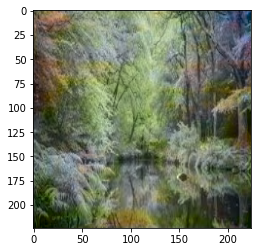

In [ ]:
# import model trained for 10000 epochs and apply on test images
model = tf.keras.models.load_model('/content/drive/MyDrive/Image colorizer/colorize_autoencoder_VGG16_10000.model')

test = img_to_array(load_img("/content/drive/MyDrive/Image colorizer/Test/autumn22.jpg"))
test = resize(test, (224, 224), anti_aliasing = True)
test *= 1.0/255
lab = rgb2lab(test)
l = lab[:,:,0]
L = gray2rgb(l)
L = L.reshape((1, 224, 224, 3))
vggpred = newmodel.predict(L)
ab = model.predict(vggpred)
ab = ab*128
cur = np.zeros((224, 224, 3))
cur[:,:,0] = l
cur[:,:,1:] = ab
plt.imshow(lab2rgb(cur))

In [ ]:
def colorize(img_path):
  test = img_to_array(load_img(img_path))
  test = resize(test, (224, 224), anti_aliasing = True)
  test *= 1.0/255
  lab = rgb2lab(test)
  l = lab[:,:,0]
  L = gray2rgb(l)
  L = L.reshape((1, 224, 224, 3))
  vggpred = newmodel.predict(L)
  ab = model.predict(vggpred)
  ab = ab*128
  cur = np.zeros((224, 224, 3))
  cur[:,:,0] = l
  cur[:,:,1:] = ab
  plt.imshow(lab2rgb(cur))

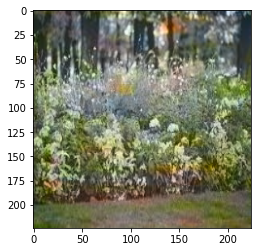

In [ ]:
colorize("/content/drive/MyDrive/Image colorizer/Test/garden32.jpg")

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 49 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


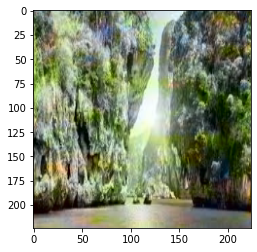

In [ ]:
colorize("/content/drive/MyDrive/Image colorizer/Test/destinations48.jpg")

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


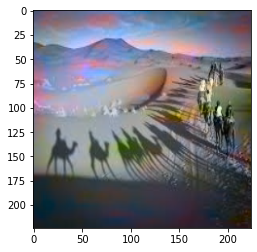

In [ ]:
colorize("/content/drive/MyDrive/Image colorizer/Test/desert26.jpg")

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 15 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


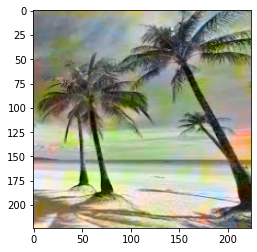

In [ ]:
colorize("/content/drive/MyDrive/Image colorizer/Test/beach21.jpg")

In [ ]:
# Need to train more for better results